In [9]:
%matplotlib inline
import polars as pl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns

# Make the graphs a bit prettier, and bigger``
plt.style.use('ggplot')

pl.Config.set_tbl_cols(60)
pl.Config.set_fmt_str_lengths(5000)

plt.rcParams['figure.figsize'] = (15, 5)

# Set Polars to show all rows without truncation
pl.Config.set_tbl_rows(-1)  # -1 means no limit

polars.config.Config

In [10]:
langs = pl.read_csv('data/World_Languages.csv')
langs[0:5]

X,Y,OBJECTID,SOVEREIGNT,TYPE_,COUNTRY,FIRST_OFFI,SECOND_OFF,THIRD_OFFI,ENGLISH_FI,FRENCH_FIR,ARABIC_FIR,SPANISH_FI,PORTUGUESE,CHINESE_FI,RUSSIAN_FI,WORLD_LANG
f64,f64,i64,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,str
24.471441,-22.345302,20,"""Botswana""","""Sovereign country""","""Botswana""","""English""",null,null,1,0,0,0,0,0,0,"""English"""
20.633118,6.614791,21,"""Central African Republic""","""Sovereign country""","""Central African Republic""","""French""","""Sangho""",null,0,1,0,0,0,0,0,"""French"""
-110.430879,56.836921,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""
-69.684882,67.856696,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""
-76.784377,79.622971,22,"""Canada""","""Sovereign country""","""Canada""","""English""","""French""",null,1,1,0,0,0,0,0,"""English_French"""


In [11]:
continents = pl.read_csv('data/Countries_Continents.csv')
continents[0:5]

Continent,Country
str,str
"""Africa""","""Algeria"""
"""Africa""","""Angola"""
"""Africa""","""Benin"""
"""Africa""","""Botswana"""
"""Africa""","""Burkina Faso"""


In [12]:
print(langs.schema)
print(continents.schema)

Schema([('X', Float64), ('Y', Float64), ('OBJECTID', Int64), ('SOVEREIGNT', String), ('TYPE_', String), ('COUNTRY', String), ('FIRST_OFFI', String), ('SECOND_OFF', String), ('THIRD_OFFI', String), ('ENGLISH_FI', Int64), ('FRENCH_FIR', Int64), ('ARABIC_FIR', Int64), ('SPANISH_FI', Int64), ('PORTUGUESE', Int64), ('CHINESE_FI', Int64), ('RUSSIAN_FI', Int64), ('WORLD_LANG', String)])
Schema([('Continent', String), ('Country', String)])


# FRENCH

In [13]:
french=langs.filter(((langs['FIRST_OFFI'] == 'French') | (langs['SECOND_OFF'] == 'French')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(french['COUNTRY'].n_unique())
french['COUNTRY'].unique().sort()

29


COUNTRY
str
"""Algeria"""
"""Belgium"""
"""Benin"""
"""Burkina Faso"""
"""Burundi"""
"""Cameroon"""
"""Canada"""
"""Central African Republic"""
"""Chad"""


In [14]:
countries_with_continents = french.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).select([
    'COUNTRY',
    'Continent'
]).unique().sort(pl.col('Continent'))  # Remove duplicates if any

print("Countries and their Continents:")
countries_with_continents

Countries and their Continents:


COUNTRY,Continent
str,str
"""Gabon""","""Africa"""
"""Madagascar""","""Africa"""
"""Mauritius""","""Africa"""
"""Chad""","""Africa"""
"""Togo""","""Africa"""
"""Senegal""","""Africa"""
"""Ivory Coast""","""Africa"""
"""Central African Republic""","""Africa"""
"""Mali""","""Africa"""


In [15]:
countries_per_continent = french.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).group_by('Continent')\
 .agg(
     pl.col('COUNTRY').n_unique().alias('country_count')
 )\
 .sort('country_count', descending=True)

countries_per_continent

Continent,country_count
str,u32
"""Africa""",22
"""Europe""",5
"""North America""",2


# ENGLISH

In [16]:
english=langs.filter(((langs['FIRST_OFFI'] == 'English') | (langs['SECOND_OFF'] == 'English')) 
                    & ((langs['TYPE_'] == 'Sovereign country')|(langs['TYPE_'] == 'Country'))
                    & (langs['SOVEREIGNT'] == langs['COUNTRY'])
                    )
print(english['COUNTRY'].n_unique())
english['COUNTRY'].unique().sort()

53


COUNTRY
str
"""Antigua and Barbuda"""
"""Australia"""
"""Barbados"""
"""Belize"""
"""Botswana"""
"""Cameroon"""
"""Canada"""
"""Denmark"""
"""Dominica"""


In [17]:
countries_with_continents = english.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).select([
    'COUNTRY',
    'Continent'
]).unique().sort(pl.col('Continent'))  # Remove duplicates if any

print("Countries and their Continents:")
countries_with_continents

Countries and their Continents:


COUNTRY,Continent
str,str
"""Sierra Leone""","""Africa"""
"""Botswana""","""Africa"""
"""Sudan""","""Africa"""
"""Cameroon""","""Africa"""
"""Swaziland""","""Africa"""
"""Ghana""","""Africa"""
"""Liberia""","""Africa"""
"""South Africa""","""Africa"""
"""Mauritius""","""Africa"""


In [18]:
countries_per_continent = english.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).group_by('Continent')\
 .agg(
     pl.col('COUNTRY').n_unique().alias('country_count')
 )\
 .sort('country_count', descending=True)

countries_per_continent

Continent,country_count
str,u32
"""Africa""",20
"""Oceania""",12
"""North America""",12
"""Europe""",4
"""Asia""",4
"""South America""",1


In [24]:
def plot_countries(df, title):    
    plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.gridlines(draw_labels=True)
    
    # Plot points using seaborn
    sns.scatterplot(
        data=df.to_pandas(),
        x='X', 
        y='Y',
        ax=ax,
        color='red',
        s=100,  # Size of points
        transform=ccrs.PlateCarree()
    )
    
    plt.title(title)

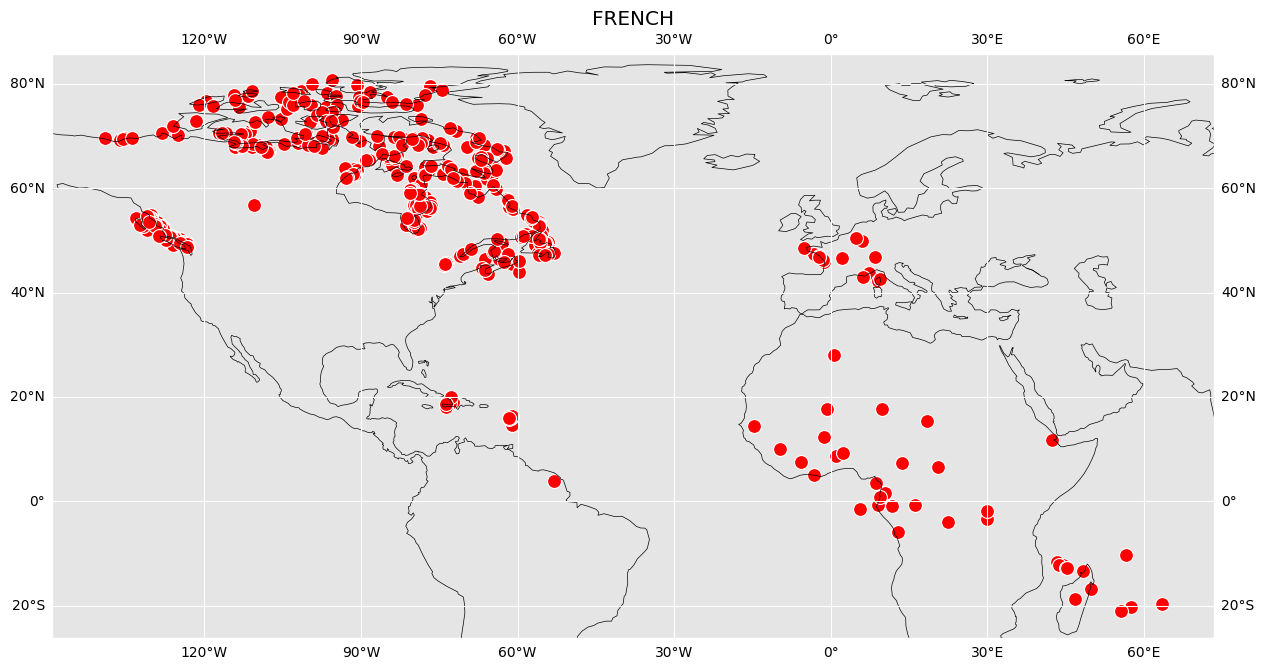

In [31]:
f2=french.join(
    continents,
    left_on='COUNTRY',
    right_on='Country',
    how='left'
).select([
    'COUNTRY'
]).unique()

french_with_coords = f2.join(
    langs,
    left_on='COUNTRY',
    right_on='COUNTRY',
    how='left'
).select([
    'X',
    'Y'
])
plot_countries(french_with_coords, 'FRENCH')
